In [71]:
import os
import pandas as pd
import pandas_profiling as pdp
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
%matplotlib inline
np.set_printoptions(precision=3)
pd.options.display.precision = 3

In [243]:
train_data = "train.csv"
test_data = "test.csv"
train_df, test_df = pd.read_csv(train_data), pd.read_csv(test_data)
train_df.head()

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,0,23.060,6,140,110,2815,17.977,80,1,dodge aspen
1,3,17.675,8,350,150,4456,13.515,72,1,dodge rampage
2,4,17.136,8,302,140,2774,13.210,79,1,mercury cougar brougham
3,7,22.665,6,400,85,2190,15.196,71,1,pontiac j2000 se hatchback
4,9,17.872,8,429,220,2245,9.621,70,1,ford galaxie 500


In [244]:
profile = pdp.ProfileReport(train_df)
profile.to_file("myoutputfile.html")

In [286]:
def CreateLabelencodingFeatures(input_df: pd.DataFrame) -> pd.DataFrame:
    use_columns = [
        'horsepower',
        'car name',
    ]
    le_res = pd.DataFrame()
    for c in use_columns:
        le = preprocessing.LabelEncoder()
        le.fit(input_df[c])
        le_res[c] = le.transform(input_df[c])
    return le_res.copy().add_prefix("CL_")

In [287]:
def CreateOnehotEncodingFeatures(input_df: pd.DataFrame) -> pd.DataFrame:
    use_columns = [
        'origin', 
        'cylinders',
        'model year',
    ]
    oh_res = pd.DataFrame()
    for c in use_columns:
        series = input_df[c]
        cat = pd.Categorical(series, categories=input_df[c].dropna().unique())
        _df = pd.get_dummies(cat)
        _df.columns = _df.columns.tolist()
        _df = _df.add_prefix(c + '=')
        oh_res = pd.concat([oh_res.copy(), _df], axis=1)

    return oh_res.add_prefix('OH_')

In [288]:
def CreateCountEncodingFeatures(input_df: pd.DataFrame) -> pd.DataFrame:
    use_columns = [
        'displacement',
        'weight',
        'acceleration',
    ]
    res_ce = pd.DataFrame()
    for c in use_columns:
        series = input_df[c]
        vc = series.value_counts(dropna=False)
        _df = pd.DataFrame(input_df[c].map(vc))
        res_ce = pd.concat([res_ce, _df], axis=1)
    return res_ce.copy().add_prefix('CE_')

In [289]:
def CreateHashEncodingFeatures(input_df: pd.DataFrame, digits: int) -> pd.DataFrame:
    use_columns = [
        '', '', ''
    ]
    res_hash = pd.DataFrame()
    for c in use_columns:
        ce = preprocessing.HashingEncoder(cols = input_df[c], n_components = digits)
        ce.fit(input_df[c])
        res_hash = ce.transform(input_df[c])
        
    return res_hash.add_prefix("HE_")

In [290]:
def CreateContinuousFeatures(input_df: pd.DataFrame) -> pd.DataFrame:
    use_columns = [
#         'id',  
#         'model year',
#         'origin'
    ]
    return input_df[use_columns].copy()

In [291]:
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [292]:
from tqdm import tqdm_notebook as tqdm

def to_feature(input_df):
    processors = [
#         CreateContinuousFeatures,
        CreateLabelencodingFeatures,
        CreateOnehotEncodingFeatures,
        CreateCountEncodingFeatures,
    ]

    out_df = pd.DataFrame()

    for func in tqdm(processors, total=len(processors)):
        with timer(prefix='create ' + func.__name__ + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

In [293]:
train_feat_df = to_feature(train_df)
test_feat_df = to_feature(test_df)

<ipython-input-292-7b68d0469910>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for func in tqdm(processors, total=len(processors)):


create CreateLabelencodingFeatures 0.002[s]
create CreateOnehotEncodingFeatures 0.011[s]
create CreateCountEncodingFeatures 0.006[s]



create CreateLabelencodingFeatures 0.004[s]
create CreateOnehotEncodingFeatures 0.012[s]
create CreateCountEncodingFeatures 0.008[s]



In [294]:
train_feat_df.head()

,CL_horsepower,OH_origin=1,OH_origin=2,OH_origin=3,OH_cylinders=6,OH_cylinders=8,OH_cylinders=4,OH_model year=80,OH_model year=72,OH_model year=79,...,OH_car name=plymouth champ,OH_car name=ford gran torino (sw),OH_car name=toyota corolla,OH_car name=datsun 1200,OH_car name=dodge coronet custom,OH_car name=volkswagen jetta,OH_car name=dodge omni,CE_displacement,CE_weight,CE_acceleration
0,3,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,65,16,1
1,14,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,20,13,1
2,11,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,38,22,1
3,33,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,30,10,1
4,17,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,15,14,1


In [301]:
from sklearn.model_selection import StratifiedKFold, train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    train_feat_df, train_df['mpg'], test_size=0.2, random_state=0
)
print(len(X_train))
print(len(X_test))
K_fold = StratifiedKFold(n_splits=5, shuffle=True,  random_state=0)

400
100


In [296]:
import lightgbm as lgb

params = {'metric': 'rmse',
          'max_depth' : 30}
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test)

model = lgb.train(params,
                  lgb_train,
                  valid_sets = lgb_eval,
                  num_boost_round = 10000,
                  early_stopping_rounds=1000,
                  verbose_eval=50)

pred = model.predict(X_test)

Training until validation scores don't improve for 1000 rounds
[50]	valid_0's rmse: 3.41262
[100]	valid_0's rmse: 3.17197
[150]	valid_0's rmse: 3.14887
[200]	valid_0's rmse: 3.13976
[250]	valid_0's rmse: 3.15979
[300]	valid_0's rmse: 3.17634
[350]	valid_0's rmse: 3.16711
[400]	valid_0's rmse: 3.173
[450]	valid_0's rmse: 3.17849
[500]	valid_0's rmse: 3.18835
[550]	valid_0's rmse: 3.18959
[600]	valid_0's rmse: 3.19982
[650]	valid_0's rmse: 3.2056
[700]	valid_0's rmse: 3.20596
[750]	valid_0's rmse: 3.20825
[800]	valid_0's rmse: 3.21191
[850]	valid_0's rmse: 3.21671
[900]	valid_0's rmse: 3.21951
[950]	valid_0's rmse: 3.2246
[1000]	valid_0's rmse: 3.23072
[1050]	valid_0's rmse: 3.23725
[1100]	valid_0's rmse: 3.24245
[1150]	valid_0's rmse: 3.25193
[1200]	valid_0's rmse: 3.25546
Early stopping, best iteration is:
[213]	valid_0's rmse: 3.13277


In [297]:
#関数の処理で必要なライブラリ
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
 
#予測値と正解値を描写する関数
def Pred_map(pred_df):
    RMSE = np.sqrt(mean_squared_error(pred_df['true'], pred_df['pred']))
    R2 = r2_score(pred_df['true'], pred_df['pred']) 
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111)
    ax.scatter('true', 'pred', data=pred_df)
    ax.set_xlabel('True Value', fontsize=15)
    ax.set_ylabel('Pred Value', fontsize=15)
    ax.set_xlim(pred_df.min().min()-0.1 , pred_df.max().max()+0.1)
    ax.set_ylim(pred_df.min().min()-0.1 , pred_df.max().max()+0.1)
    x = np.linspace(pred_df.min().min()-0.1, pred_df.max().max()+0.1, 2)
    y = x
    ax.plot(x,y,'r-')
    plt.text(0.1, 0.9, 'RMSE = {}'.format(str(round(RMSE, 5))), transform=ax.transAxes, fontsize=15)
    plt.text(0.1, 0.8, 'R^2 = {}'.format(str(round(R2, 5))), transform=ax.transAxes, fontsize=15)

In [298]:
pred_df = pd.concat([y_test.reset_index(drop=True), pd.Series(pred)], axis=1)
pred_df.columns = ['true', 'pred']

In [299]:
pred_df.head()

,true,pred
0,22.814,22.176
1,17.686,18.494
2,33.528,35.062
3,26.606,22.802
4,22.913,22.018


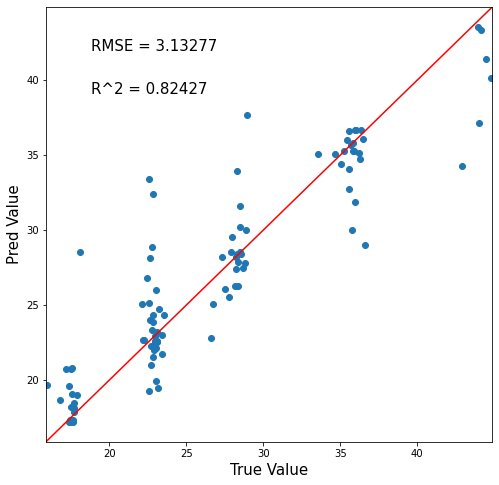

In [300]:
Pred_map(pred_df)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

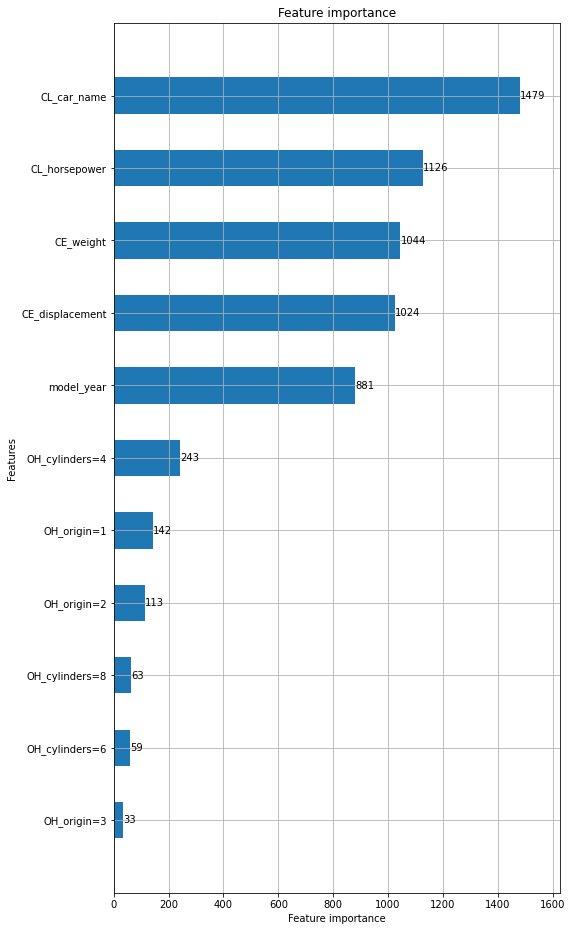

In [260]:
lgb.plot_importance(model, height=0.5, figsize=(8,16))

In [265]:
train_feat_df.head()

,model year,CL_horsepower,CL_car name,OH_origin=1,OH_origin=2,OH_origin=3,OH_cylinders=6,OH_cylinders=8,OH_cylinders=4,CE_displacement,CE_weight,CE_acceleration
0,80,3,29,1,0,0,1,0,0,65,16,1
1,72,14,35,1,0,0,0,1,0,20,13,1
2,79,11,51,1,0,0,0,1,0,38,22,1
3,71,33,62,1,0,0,1,0,0,30,10,1
4,70,17,40,1,0,0,0,1,0,15,14,1


In [268]:
pred = model.predict(test_feat_df)

pred_df = pd.DataFrame(pred, index = test_df.id)

In [269]:
pred_df

,0
id,
1,21.778
2,22.879
5,21.544
6,20.736
8,19.678
...,...
992,20.844
993,23.600
996,21.527


In [270]:
pred_df.to_csv('ans01.csv', header=False, index=True)

## CountEncoding 

In [ ]:
def create_uid_aggregation_feature(input_df: pd.DataFrame) -> pd.DataFrame:
    """uid に関する aggregation 特徴量"""

    # note: 
    #   この集約はとても重たい処理になりがちです(特にnunique). しかも train / test で共通の処理で毎回 call されるため無駄です
    #   例えば別のコードで `_agg_df` だけ作ってローカルに保存するコードをかいておいて
    #   実際に特徴量を作成するときにはそちらを読み込む用にするなどすると高速化になります
    _agg_df = pd.concat([
        whole_df.groupby('uid')['last_login_interval'].agg(['mean', 'std']).add_prefix('last_login_interval_'),
        whole_df.groupby('uid')['advertiser_id'].nunique()
    ], axis=1)

    out_df = pd.merge(input_df['uid'], _agg_df, on='uid', how='left')
    out_df = out_df.drop(columns='uid').add_suffix('_by_uid')
    return out_df